In [58]:
#============================================================================
# merge_cloud_stats.ipynb
# Utility: Merges cloud stats. Also used to identify and plot fog
# statistics.
#
# Author: McKenna W. Stanford
#============================================================================

In [1]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from file_struct import file_struct as fs
from load_sonde_data import load_sonde_data
from give_me_files_and_subfolders import give_me_files_and_subfolders
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.patches as mpatches
from dask.distributed import Client, progress, LocalCluster
import time
import ctypes
#from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                  mark_inset)
import seaborn as sns

In [2]:
#--------------------------------------------
# Functions 
#--------------------------------------------

#--------------------------------------------
# Trim Memory
#--------------------------------------------
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)


In [3]:
#path = '/mnt/raid/mwstanfo/micre_cloud_properties/'
path = '/mnt/raid/mwstanfo/micre/cloud_precip_property_files/'
#files = glob.glob(path+'micre_cloud_properties_dm|in*.p')
files = glob.glob(path+'micre_cloud_properties*.p')
files = sorted(files)
num_files = len(files)
print(num_files)

345


In [4]:
cluster = LocalCluster(n_workers=8,threads_per_worker=1,memory_limit='2GB',processes=True)
cluster

LocalCluster(dc438abe, 'tcp://127.0.0.1:34040', workers=8, threads=8, memory=14.90 GiB)

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34040,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:40160,Total threads: 1
Dashboard: http://127.0.0.1:35933/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:37248,


In [6]:
def read_in_file(infile):

   
    keys = ['time_dt','ctt','cbt','cth','cbh','c_thick','precip_binary','cloud_binary',\
            'cbh_bel_min_binary','bad_radar_data_flag',\
            'ref_mean_bel','vel_min_bel','temperature_mean_bel','Z_min_mean_bel','precip_to_sfc_binary',\
            'virga_binary','virga_base_height','ref_grad_above','ref_grad_below','ref_through_100m_above_binary','ref_through_100m_below_binary',\
            'IWflx','LWflx','rcb','ref_above_cbh_binary','ref_below_cbh_binary','precip_updraft_binary',\
            'sfc_precip_binary','sfc_precip_updraft_binary','sfc_IWflx','sfc_LWflx','sfc_rcb',\
            'sfc_ref_mean','sfc_vel_min','sfc_temperature_mean','num_ref_cloud_layers_in_profile',\
            'num_ceil_cbh_in_profile','nearest_ref_above_cbh','nearest_ref_below_cbh','single_layer_binary',\
            'ref_at_cbh_binary','ref_within_100m_above_cbh_binary','ref_within_100m_below_cbh_binary','cloud_50m_thick_binary',\
            'ceil_detection_status','sfc_ref_grad','sfc_ref_through_100m_binary','sfc_cloud_binary','fog_mask','fog_mask_2']
            
    var_dict = {}
    pkl_dict = pickle.load(open(infile,"rb"))
    print(pkl_dict.keys())
    flags_dict = pkl_dict['flags']
    sfc_met_flag = flags_dict['sfc_met_flag']
    ceil_flag = flags_dict['ceil_flag']
    interp_sonde_flag = flags_dict['interp_sonde_flag']
    
    if not ceil_flag:
        var_dict = None
        return var_dict
        
    if sfc_met_flag:
        var_dict['sfc_met_rh']  = pkl_dict['sfc_met_rh']
        var_dict['sfc_met_temperature']  = pkl_dict['sfc_met_temperature']
        var_dict['sfc_met_pressure']  = pkl_dict['sfc_met_pressure']
        var_dict['sfc_met_wind_dir']  = pkl_dict['sfc_met_wind_dir']
        var_dict['sfc_met_wind_speed']  = pkl_dict['sfc_met_wind_speed']
    else:
        dummy_array = np.zeros(np.shape(pkl_dict['time_dt']))
        var_dict['sfc_met_rh'] = dummy_array-999.
        var_dict['sfc_met_temperature'] = dummy_array-999.
        var_dict['sfc_met_pressure'] = dummy_array-999.
        var_dict['sfc_met_wind_speed'] = dummy_array-999.
        var_dict['sfc_met_wind_dir'] = dummy_array-999.
        
    if interp_sonde_flag:
        var_dict['seconds_to_nearest_sounding'] = pkl_dict['seconds_to_nearest_sounding']
        var_dict['cluster_id'] = pkl_dict['cluster_id']
    else:
        dummy_array = np.zeros(np.shape(pkl_dict['time_dt']))
        var_dict['seconds_to_nearest_sounding'] = dummy_array-999.
        var_dict['cluster_id'] = dummy_array-999.

    for key in keys:
        var_dict[key] = pkl_dict[key]
            
    return var_dict

In [7]:
keys = ['time_dt','ctt','cbt','cth','cbh','c_thick','precip_binary','cloud_binary',\
        'cbh_bel_min_binary','bad_radar_data_flag',\
        'ref_mean_bel','vel_min_bel','temperature_mean_bel','Z_min_mean_bel','precip_to_sfc_binary',\
        'virga_binary','virga_base_height','ref_grad_above','ref_grad_below','ref_through_100m_above_binary','ref_through_100m_below_binary',\
        'IWflx','LWflx','rcb','ref_above_cbh_binary','ref_below_cbh_binary','precip_updraft_binary',\
        'sfc_precip_binary','sfc_precip_updraft_binary','sfc_IWflx','sfc_LWflx','sfc_rcb',\
        'sfc_ref_mean','sfc_vel_min','sfc_temperature_mean','num_ref_cloud_layers_in_profile',\
        'num_ceil_cbh_in_profile','nearest_ref_above_cbh','nearest_ref_below_cbh','cluster_id','single_layer_binary',\
        'ref_at_cbh_binary','ref_within_100m_above_cbh_binary','ref_within_100m_below_cbh_binary','cloud_50m_thick_binary',\
        'ceil_detection_status','sfc_ref_grad','sfc_ref_through_100m_binary','sfc_cloud_binary','fog_mask','fog_mask_2',\
        'sfc_met_rh','sfc_met_temperature','sfc_met_pressure','sfc_met_wind_speed','sfc_met_wind_dir','seconds_to_nearest_sounding']

var_dict_2 = {}
for key in keys:
    var_dict_2[key] = []

In [8]:
futures = client.map(read_in_file,files)

dict_keys(['ctt', 'cbt', 'cbh', 'cth', 'c_thick', 'IWflx', 'LWflx', 'rcb', 'ref_mean_bel', 'vel_min_bel', 'temperature_mean_bel', 'Z_min_mean_bel', 'virga_binary', 'virga_base_height', 'cloud_binary', 'precip_binary', 'precip_to_sfc_binary', 'precip_updraft_binary', 'single_layer_binary', 'cbh_bel_min_binary', 'ref_at_cbh_binary', 'ref_within_100m_above_cbh_binary', 'ref_within_100m_below_cbh_binary', 'ref_above_cbh_binary', 'ref_below_cbh_binary', 'cloud_50m_thick_binary', 'ref_through_100m_above_binary', 'ref_through_100m_below_binary', 'num_ref_cloud_layers_in_profile', 'num_ceil_cbh_in_profile', 'nearest_ref_above_cbh', 'nearest_ref_below_cbh', 'ref_grad_above', 'ref_grad_below', 'sfc_met_temperature', 'sfc_met_rh', 'sfc_met_wind_speed', 'sfc_met_wind_dir', 'sfc_met_pressure', 'sfc_ref_mean', 'sfc_temperature_mean', 'sfc_rh_mean', 'sfc_ref_grad', 'sfc_vel_min', 'sfc_IWflx', 'sfc_LWflx', 'sfc_rcb', 'sfc_precip_binary', 'sfc_cloud_binary', 'sfc_precip_updraft_binary', 'sfc_ref_throug

In [9]:
results = client.gather(futures)

dict_keys(['ctt', 'cbt', 'cbh', 'cth', 'c_thick', 'IWflx', 'LWflx', 'rcb', 'ref_mean_bel', 'vel_min_bel', 'temperature_mean_bel', 'Z_min_mean_bel', 'virga_binary', 'virga_base_height', 'cloud_binary', 'precip_binary', 'precip_to_sfc_binary', 'precip_updraft_binary', 'single_layer_binary', 'cbh_bel_min_binary', 'ref_at_cbh_binary', 'ref_within_100m_above_cbh_binary', 'ref_within_100m_below_cbh_binary', 'ref_above_cbh_binary', 'ref_below_cbh_binary', 'cloud_50m_thick_binary', 'ref_through_100m_above_binary', 'ref_through_100m_below_binary', 'num_ref_cloud_layers_in_profile', 'num_ceil_cbh_in_profile', 'nearest_ref_above_cbh', 'nearest_ref_below_cbh', 'ref_grad_above', 'ref_grad_below', 'sfc_met_temperature', 'sfc_met_rh', 'sfc_met_wind_speed', 'sfc_met_wind_dir', 'sfc_met_pressure', 'sfc_ref_mean', 'sfc_temperature_mean', 'sfc_rh_mean', 'sfc_ref_grad', 'sfc_vel_min', 'sfc_IWflx', 'sfc_LWflx', 'sfc_rcb', 'sfc_precip_binary', 'sfc_cloud_binary', 'sfc_precip_updraft_binary', 'sfc_ref_throug

In [10]:
client.shutdown()

dict_keys(['ctt', 'cbt', 'cbh', 'cth', 'c_thick', 'IWflx', 'LWflx', 'rcb', 'ref_mean_bel', 'vel_min_bel', 'temperature_mean_bel', 'Z_min_mean_bel', 'virga_binary', 'virga_base_height', 'cloud_binary', 'precip_binary', 'precip_to_sfc_binary', 'precip_updraft_binary', 'single_layer_binary', 'cbh_bel_min_binary', 'ref_at_cbh_binary', 'ref_within_100m_above_cbh_binary', 'ref_within_100m_below_cbh_binary', 'ref_above_cbh_binary', 'ref_below_cbh_binary', 'cloud_50m_thick_binary', 'ref_through_100m_above_binary', 'ref_through_100m_below_binary', 'num_ref_cloud_layers_in_profile', 'num_ceil_cbh_in_profile', 'nearest_ref_above_cbh', 'nearest_ref_below_cbh', 'ref_grad_above', 'ref_grad_below', 'sfc_met_temperature', 'sfc_met_rh', 'sfc_met_wind_speed', 'sfc_met_wind_dir', 'sfc_met_pressure', 'sfc_ref_mean', 'sfc_temperature_mean', 'sfc_rh_mean', 'sfc_ref_grad', 'sfc_vel_min', 'sfc_IWflx', 'sfc_LWflx', 'sfc_rcb', 'sfc_precip_binary', 'sfc_cloud_binary', 'sfc_precip_updraft_binary', 'sfc_ref_throug

In [11]:
for ii in range(len(results)):
    out_var_dict = results[ii]
    if out_var_dict is None:
        continue
    for key in out_var_dict.keys():
        var_dict_2[key].append(out_var_dict[key])

In [12]:
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------
# Concatenate Dates
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------
for key in var_dict_2.keys():
    #print(key)
    var_dict_2[key] = np.concatenate(var_dict_2[key])

In [13]:
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
# Print size of dataset
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
dumsize = np.size(var_dict_2['time_dt'])
print('Total # of data points: {}'.format(dumsize))

Total # of data points: 2417975


In [14]:
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
# Limit all variable arrays to only include values good radar data
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
dumid = np.where( (var_dict_2['bad_radar_data_flag'] == 0.) )
dumsize1 = np.size(var_dict_2['time_dt'])
dumsize2 = np.size(dumid)
print('Total # of data points: {}'.format(dumsize1))
print('Total # of data points after removing bad_radar_data: {}'.format(dumsize2))
print('% of data points after filtering: {} %'.format(dumsize2/dumsize1*100.))

Total # of data points: 2417975
Total # of data points after removing bad_radar_data: 2230934
% of data points after filtering: 92.26456022084596 %


In [15]:
for key in var_dict_2.keys():
    #print(key)
    var_dict_2[key] = var_dict_2[key][dumid]

In [16]:
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
# Limit all variable arrays to only include values with good CEIL data
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
dumid = np.where(~np.isnan(var_dict_2['ceil_detection_status']))
dumsize1 = np.size(var_dict_2['time_dt'])
dumsize2 = np.size(dumid)
print('Total # of data points: {}'.format(dumsize1))
print('Total # of data points after removing bad CEIL data: {}'.format(dumsize2))
print('% of data points after filtering: {} %'.format(dumsize2/dumsize1*100.))

Total # of data points: 2230934
Total # of data points after removing bad CEIL data: 2159692
% of data points after filtering: 96.80662897243934 %


In [17]:
for key in var_dict_2.keys():
    #print(key)
    var_dict_2[key] = var_dict_2[key][dumid]

In [18]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Calculate percentage of updrafts below cloud base and output
# percentage
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
dumid = np.where(var_dict_2['precip_updraft_binary'] == 1.)
print('% of profiles w/ updrafts below cloud base for both precipitating and nonprecipitating layers: {} %'.format(np.size(dumid)/np.size(var_dict_2['precip_updraft_binary'])*100.))
precip_id = np.where(var_dict_2['precip_binary'] == 1.)
precip_updraft_id = np.where(var_dict_2['precip_updraft_binary'] == 1.)
print('% of profiles w/ updrafts below cloud base for only precipitating layers and sub-cloud updraft layers: {} %'.format(np.size(precip_updraft_id)/(np.size(precip_updraft_id) + np.size(precip_id))*100.))

% of profiles w/ updrafts below cloud base for both precipitating and nonprecipitating layers: 1.3909853812488078 %
% of profiles w/ updrafts below cloud base for only precipitating layers and sub-cloud updraft layers: 3.410479040556557 %


In [19]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Remove updrafts
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
no_updraft_id = np.where((var_dict_2['precip_updraft_binary'] == 0.) | (var_dict_2['precip_updraft_binary'] == -999.))[0]
for key in var_dict_2.keys():
    #print(key)
    var_dict_2[key] = var_dict_2[key][no_updraft_id]

In [20]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Create new dictionary that is limited to only points with elevated cloud
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
cloud_id = np.where(var_dict_2['cloud_binary'] == 1.)[0]
var_dict_cloud = var_dict_2.copy()
for key in var_dict_cloud.keys():
    #print(key)
    var_dict_cloud[key] = var_dict_cloud[key][cloud_id]

In [21]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Create new dictionary that is limited to only points with SFC cloud
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
sfc_cloud_id = np.where((var_dict_2['cbh'] > -999.) & (var_dict_2['cbh'] < 250.) )[0]
var_dict_sfc_cloud = var_dict_2.copy()
for key in var_dict_sfc_cloud.keys():
    var_dict_sfc_cloud[key] = var_dict_sfc_cloud[key][sfc_cloud_id]

2023-01-31 21:12:35,730 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [22]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Perform other limiting controls
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
dumid = np.where( (var_dict_cloud['cbt'] > -38.) & (var_dict_cloud['ctt'] > -38.) )
for key in var_dict_cloud.keys():
    var_dict_cloud[key] = var_dict_cloud[key][dumid]

In [23]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Get months for elevated clouds
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
var_dict_cloud['months'] = np.zeros(len(var_dict_cloud['cbt']))
for ii in range(len(var_dict_cloud['cbt'])):
    var_dict_cloud['months'][ii] = var_dict_cloud['time_dt'][ii].month

In [24]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Get months for SFC clouds
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
var_dict_sfc_cloud['months'] = np.zeros(len(var_dict_sfc_cloud['cbt']))
for ii in range(len(var_dict_sfc_cloud['cbt'])):
    var_dict_sfc_cloud['months'][ii] = var_dict_sfc_cloud['time_dt'][ii].month

In [83]:
save_path = '/mnt/raid/mwstanfo/micre/'
out_pkl_file = save_path+'micre_cloud_properties_dict_all_vb.p'
pickle.dump(var_dict_cloud,open(out_pkl_file,"wb"))

2022-12-14 13:47:43,637 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [25]:
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
# Calculate Monthly Cloud Occurrence Frequency
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
cbh = var_dict_2['cbh']
cbt = var_dict_2['cbt']
cth = var_dict_2['cth']
ctt = var_dict_2['ctt']
c_thick = var_dict_2['c_thick']
fog_mask = var_dict_2['fog_mask']
ref_at_cbh_binary = var_dict_2['ref_at_cbh_binary']
cloud_binary = var_dict_2['cloud_binary']
precip_binary = var_dict_2['precip_binary']
ceil_detection_status = var_dict_2['ceil_detection_status']
time_dt = var_dict_2['time_dt']

cloud_cbh = var_dict_cloud['cbh']
cloud_cbt = var_dict_cloud['cbt']
cloud_cth = var_dict_cloud['cth']
cloud_ctt = var_dict_cloud['ctt']
cloud_c_thick = var_dict_cloud['c_thick']
cloud_ref_at_cbh_binary = var_dict_cloud['ref_at_cbh_binary']
cloud_time_dt = var_dict_cloud['time_dt']

sfc_cloud_cbh = var_dict_sfc_cloud['cbh']
sfc_cloud_cbt = var_dict_sfc_cloud['cbt']
sfc_cloud_cth = var_dict_sfc_cloud['cth']
sfc_cloud_ctt = var_dict_sfc_cloud['ctt']
sfc_cloud_c_thick = var_dict_sfc_cloud['c_thick']
sfc_cloud_time_dt = var_dict_sfc_cloud['time_dt']

In [26]:
months = np.zeros(len(cbt))
for ii in range(len(cbh)):
    months[ii] = time_dt[ii].month
cloud_months = np.zeros(len(cloud_cbh))
for ii in range(len(cloud_cbh)):
    cloud_months[ii] = cloud_time_dt[ii].month
sfc_cloud_months = np.zeros(len(sfc_cloud_cbh))
for ii in range(len(sfc_cloud_cbh)):
    sfc_cloud_months[ii] = sfc_cloud_time_dt[ii].month

In [27]:
month_arr = np.arange(1,13,1)
cloud_freq_arr = []
for ii in range(len(month_arr)):
    dumid = np.where(months == month_arr[ii])
    dum_size_1 = np.size(cbh[dumid][cbh[dumid] > 0.])
    dum_size_2 = np.size(cbh[dumid][~np.isnan(cbh[dumid])])
    cloud_freq_arr.append(dum_size_1/dum_size_2)

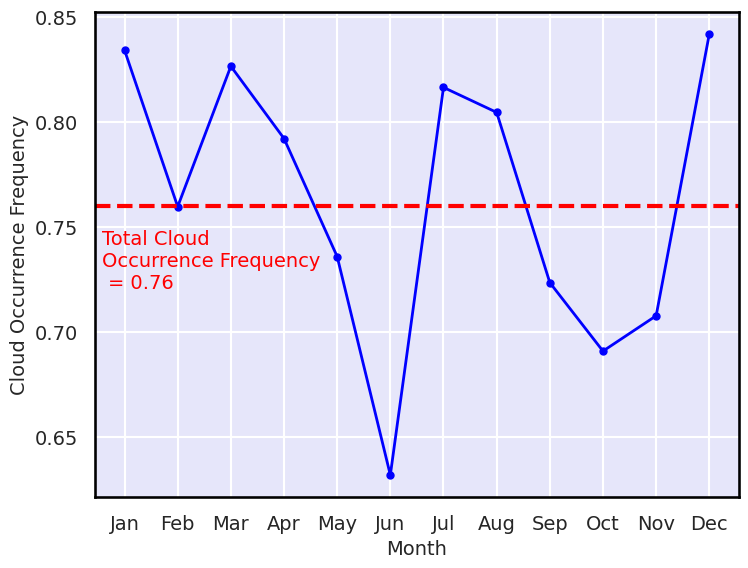

In [28]:
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('talk')

fig = plt.figure(figsize=(8.3,6.3))
ax1 = fig.add_subplot(111)
Fontsize=14


axlist = [ax1]
for ax in axlist:
    #ax.grid(which='both',ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    
ax1.plot(month_arr,cloud_freq_arr,c='blue',lw=2,marker='o',markersize=5)
ax1.set_ylabel('Cloud Occurrence Frequency',fontsize=Fontsize)
ax1.set_xlabel('Month',fontsize=Fontsize)
dum_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticks(np.arange(1,13,1))
ax1.set_xticklabels(dum_list)

ax1.axhline(0.76,lw=3,ls='dashed',c='red')
dumstr = 'Total Cloud\nOccurrence Frequency\n = 0.76'
ax1.text(0.01,0.43,dumstr,transform=ax1.transAxes,fontsize=Fontsize,c='red')


plt.show()
plt.close()

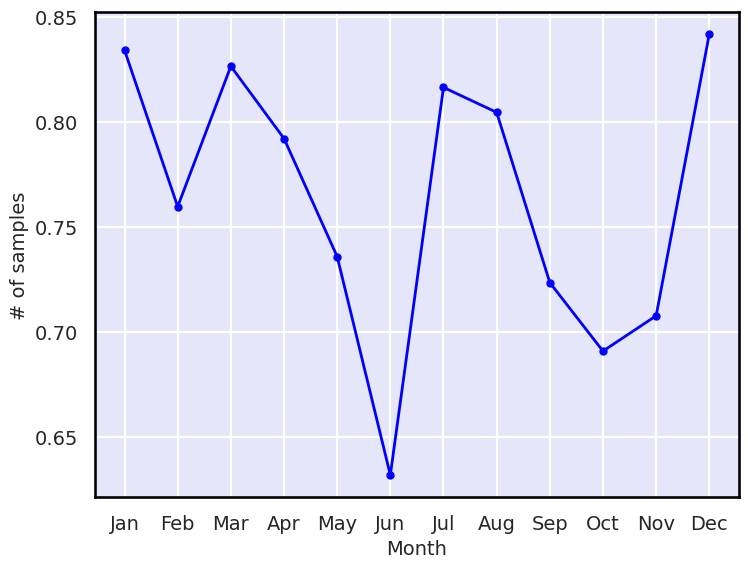

In [29]:
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('talk')

fig = plt.figure(figsize=(8.3,6.3))
ax1 = fig.add_subplot(111)
Fontsize=14


axlist = [ax1]
for ax in axlist:
    #ax.grid(which='both',ls='dotted',lw=1,c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    
ax1.plot(month_arr,cloud_freq_arr,c='blue',lw=2,marker='o',markersize=5)
ax1.set_ylabel('# of samples',fontsize=Fontsize)
ax1.set_xlabel('Month',fontsize=Fontsize)
dum_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticks(np.arange(1,13,1))
ax1.set_xticklabels(dum_list)


plt.show()
plt.close()

In [46]:
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
# Calculate Various Fractions
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
cbh = var_dict_2['cbh']
cbt = var_dict_2['cbt']
cth = var_dict_2['cth']
ctt = var_dict_2['ctt']
c_thick = var_dict_2['c_thick']
fog_mask = var_dict_2['fog_mask']
ref_at_cbh_binary = var_dict_2['ref_at_cbh_binary']
cloud_binary = var_dict_2['cloud_binary']
precip_binary = var_dict_2['precip_binary']
ceil_detection_status = var_dict_2['ceil_detection_status']

cloud_cbh = var_dict_cloud['cbh']
cloud_cbt = var_dict_cloud['cbt']
cloud_cth = var_dict_cloud['cth']
cloud_ctt = var_dict_cloud['ctt']
cloud_c_thick = var_dict_cloud['c_thick']
cloud_ref_at_cbh_binary = var_dict_cloud['ref_at_cbh_binary']


sfc_cloud_cbh = var_dict_sfc_cloud['cbh']
sfc_cloud_cbt = var_dict_sfc_cloud['cbt']
sfc_cloud_cth = var_dict_sfc_cloud['cth']
sfc_cloud_ctt = var_dict_sfc_cloud['ctt']
sfc_cloud_c_thick = var_dict_sfc_cloud['c_thick']

#------------------------------------------------------------
# Total Cloud Fraction
#------------------------------------------------------------
dum_size_1 = np.size(cbh[cbh > 0.])
dum_size_2 = np.size(cbh[~np.isnan(cbh)])
print('Total Cloud Occurrence Frequency:',dum_size_1/dum_size_2*100.)
print((np.size(cloud_binary[cloud_binary == 1.]) + np.size(cloud_binary[cloud_binary == -1]))/np.size(cloud_binary)*100.)
#------------------------------------------------------------
# Fraction of layers with obscured ceilometer signal
#------------------------------------------------------------
dum_size_1 = np.size(ceil_detection_status[ceil_detection_status == 4.])
dum_size_2 = np.size(ceil_detection_status[~np.isnan(ceil_detection_status)])
print('Obscured Ceilometer Occurrence Frequency:',dum_size_1/dum_size_2*100.)

#------------------------------------------------------------
# Fraction of Clouds w/ CBH > 250.
#------------------------------------------------------------
dum_size_1 = np.size(cbh[cbh > 250.])
dum_size_2 = np.size(cbh[cbh > 0.])
print('% of Clouds w/ CBH > 250 m:',dum_size_1/dum_size_2*100.)

#------------------------------------------------------------
# Fraction of SFC-based clouds (CBH < 250 m)
#------------------------------------------------------------
dum_size_1 = np.size(np.where( (cbh > 0.) & (cbh < 250.) ) )
dum_size_2 = np.size(cbh[cbh > 0.])
print('% of SFC-based clouds (CBH < 250 m):',dum_size_1/dum_size_2*100.)
    
    
#------------------------------------------------------------
# Conditional Cloud Occurrence frequency based only on CBT for
# elevated clouds
#------------------------------------------------------------
# Supercooled
dum_size_1 = np.size(np.where( (cbt > -999.) & (cbt < 0.) & (cbh > 250.) ))
dum_size_2 = np.size(np.where( (cbt > -999.) & (cbh > 250.)))
print('% supercooled clouds based on CBT only :',dum_size_1/dum_size_2*100.)

# Warm
dum_size_1 = np.size(np.where( (cbt > -999.) & (cbt >= 0.) & (cbh > 250.) ))
dum_size_2 = np.size(np.where( (cbt > -999.)))
print('% warm clouds based on CBT only :',dum_size_1/dum_size_2*100.)


#------------------------------------------------------------
# Fraction of clouds with CEIL only - only for elevated clouds
#------------------------------------------------------------
#All
dum_size_1 = np.size(np.where( (ref_at_cbh_binary == 0.) & (cbt > -999.) & (cbh > 250.) & (cbt > -38.) ) )
dum_size_2 = np.size(np.where( (cbt > -999.) & (ref_at_cbh_binary > -999.) & (cbh > 250.) & (cbt > -38.) ) )
print('% of clouds w/ CEIL only:',dum_size_1/dum_size_2*100.)

# Supercooled
dum_size_1 = np.size(np.where( (ref_at_cbh_binary == 0.) & (cbt > -999.) & (cbt < 0.) & (cbh > 250.) ) )
dum_size_2 = np.size(np.where( (cbt > -999.) & (ref_at_cbh_binary == 0.) ) )
print('% supercooled clouds w/ CEIL only:',dum_size_1/dum_size_2*100.)

# Warm
dum_size_1 = np.size(np.where( (ref_at_cbh_binary == 0.) & (cbt > -999.) & (cbt >= 0.) & (cbh > 250.) ) )
dum_size_2 = np.size(np.where( (cbt > -999.) & (ref_at_cbh_binary == 0.) & (cbh > 250.) ) )
print('% warm clouds w/ CEIL only:',dum_size_1/dum_size_2*100.)

#print('Cloud Fraction (% of data points with CBH at any height):',(np.size(cbh[cbh > 0.])/np.size(cbh[~np.isnan(cbh)]))*100.)
#supercooled_id = np.where( (cbt > -999.) & (cth > -999.) & (cbt < 0.) & (cth < 0.) )
#partially_supercooled_id = np.where( (cbt > -999.) & (cth > -999.) & (cbt >= 0.) & (cth < 0.) )
#partially_supercooled_id = np.where( (cbt > -999.) & (cth > -999.) & (cbt >= 0.) & (cth < 0.) )

#print('% of data points with CBH == -999.:',np.size(cbh_binary_neg999_id)/np.size(cbh)*100.)
#print('% of data points with CBH < 250):',np.size(cbh_bel_min_binary_id)/np.size(cbh_bel_min_binary)*100.)
##print('% of datapoints with seconds_to_nearest_sounding == -999.:',np.size(seconds_to_nearest_sounding_neg999_id)/np.size(seconds_to_nearest_sounding)*100.)
#print('% of datapoints w/ cloud but no reflectivity at cloud base:',np.size(ref_at_cbh_binary_id)/np.size(ref_at_cbh_binary[cloud_id])*100.)
#print('% of datapoints w/ attenuated backscatter profile indicative of fog (< 250 m):',np.size(fog_mask_id)/np.size(fog_mask)*100.)
#print('% of datapoints w/ attenuated backscatter profile indicative of fog (all heights):',np.size(fog_mask_2_id)/np.size(fog_mask_2)*100.)

Total Cloud Occurrence Frequency: 75.90905797135547
78.39482181155662
Obscured Ceilometer Occurrence Frequency: 2.4650601207779705
% of Clouds w/ CBH > 250 m: 74.38384712466124
% of SFC-based clouds (CBH < 250 m): 25.61615287533876
% supercooled clouds based on CBT only : 60.693574596735814
% warm clouds based on CBT only : 39.306425403264186
% of clouds w/ CEIL only: 27.28908289215614
% supercooled clouds w/ CEIL only: 75.26478647984905
% warm clouds w/ CEIL only: 24.735213520150953


In [48]:
# Explore Fog

# First limit data
dum_ctt = var_dict_sfc_cloud['ctt'].copy()
dum_cbh = var_dict_sfc_cloud['cbh'].copy()
dum_cth = var_dict_sfc_cloud['cth'].copy()
dum_cbt = var_dict_sfc_cloud['cbt'].copy()
dum_fog_mask = var_dict_sfc_cloud['fog_mask'].copy()
dum_sfc_rh = var_dict_sfc_cloud['sfc_met_rh'].copy()
dum_sfc_wind_speed = var_dict_sfc_cloud['sfc_met_wind_speed'].copy()
dum_sfc_temperature = var_dict_sfc_cloud['sfc_met_temperature'].copy()
dum_sfc_ref_mean = var_dict_sfc_cloud['sfc_ref_mean'].copy()
dum_sfc_vel_min = var_dict_sfc_cloud['sfc_vel_min'].copy()
dum_sfc_rcb = var_dict_sfc_cloud['sfc_rcb'].copy()
dum_sfc_cloud_binary = var_dict_sfc_cloud['sfc_cloud_binary'].copy()
dum_months = var_dict_sfc_cloud['months'].copy()


dumid = np.where(dum_cbh > -999.)
dum_ctt = dum_ctt[dumid]
dum_cth = dum_cth[dumid]
dum_cbh = dum_cbh[dumid]
dum_cbt = dum_cbt[dumid]
dum_sfc_rh = dum_sfc_rh[dumid]
dum_sfc_wind_speed = dum_sfc_wind_speed[dumid]
dum_fog_mask = dum_fog_mask[dumid]
dum_sfc_ref_mean = dum_sfc_ref_mean[dumid]
dum_sfc_temperature = dum_sfc_temperature[dumid]
dum_sfc_vel_min = dum_sfc_vel_min[dumid]
dum_sfc_rcb = dum_sfc_rcb[dumid]
dum_sfc_cloud_binary = dum_sfc_cloud_binary[dumid]
dum_months = dum_months[dumid]

In [32]:
dumid = np.where(dum_fog_mask == 1.)
fog_months = dum_months[dumid]
dum = dum_fog_mask[dumid]
print(np.unique(fog_months))

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


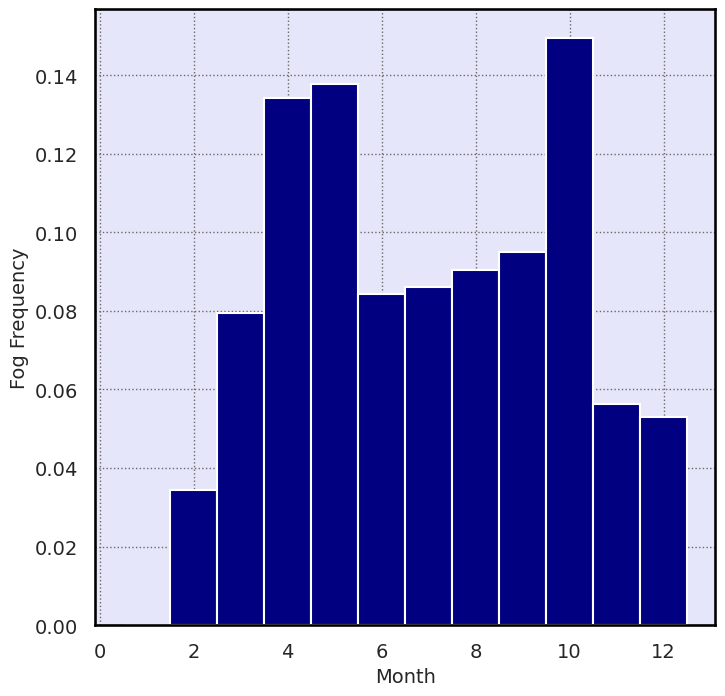

In [33]:
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('talk')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
Fontsize=14
ax.tick_params(labelsize=Fontsize)
ax.grid(which='both',c='dimgrey',ls='dotted',lw=1)
ax.set_xlabel('Month',fontsize=Fontsize)
ax.set_ylabel('Fog Frequency',fontsize=Fontsize)
bins = np.arange(0.5,13.5,1)
ax.hist(fog_months,bins=bins,density=True,color='navy')
plt.show()
plt.close()

In [34]:
dumid = np.where(dum_cbh < 250.)
print('% of CBH''s < 250 m:',np.size(dumid)/np.size(dum_cbh)*100.)

fog_id = np.where(dum_fog_mask == 1.)
print('% of times when fog_mask == 1.:',np.size(fog_id)/np.size(dum_fog_mask)*100.)

xfog_id = np.where((dum_cbh < 250.) & (dum_fog_mask == 1.))
print('% of times when fog_mask == 1. & CBH < 250 m:',np.size(xfog_id)/np.size(dum_fog_mask[dumid])*100.)

xdumid1 = np.where((dum_cbh < 250.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_ref_mean > -999.))
print('% of times when CBH < 250 m and sfc_ref_mean > -999.:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_fog_mask == 1.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_fog_mask == 1.) & (dum_sfc_ref_mean > -999.))
print('% of times when CBH < 250 m and fog_mask == 1. and and sfc_ref_mean > -999.:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_rh > -999.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_rh > 95))
print('% of times when CBH < 250 m and sfc_rh > 95%:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_rh > -999.) & (dum_fog_mask == 1.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_rh > 95.) & (dum_fog_mask == 1.))
print('% of times when CBH < 250 m and fog_mask == 1. and sfc_rh > -95%:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > -999.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > 0))
print('% of times when CBH < 250 m and sfc_temp > 0 deg C:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > -999.) & (dum_fog_mask == 1.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > 0.) & (dum_fog_mask == 1.))
print('% of times when CBH < 250 m and fog_mask == 1. and sfc_temperature > 0 deg C:',np.size(xdumid2)/np.size(xdumid1)*100.)

% of CBHs < 250 m: 100.0
% of times when fog_mask == 1.: 56.701649610767355
% of times when fog_mask == 1. & CBH < 250 m: 56.701649610767355
% of times when CBH < 250 m and sfc_ref_mean > -999.: 98.91687578191357
% of times when CBH < 250 m and fog_mask == 1. and and sfc_ref_mean > -999.: 99.46739274237257
% of times when CBH < 250 m and sfc_rh > 95%: 33.20937660706579
% of times when CBH < 250 m and fog_mask == 1. and sfc_rh > -95%: 43.49123541013841
% of times when CBH < 250 m and sfc_temp > 0 deg C: 99.9522155209154
% of times when CBH < 250 m and fog_mask == 1. and sfc_temperature > 0 deg C: 99.98933078410201


In [50]:
# Explore Fog

# First limit data
dum_ctt = var_dict_2['ctt'].copy()
dum_cbh = var_dict_2['cbh'].copy()
dum_cth = var_dict_2['cth'].copy()
dum_cbt = var_dict_2['cbt'].copy()
dum_fog_mask = var_dict_2['fog_mask'].copy()
dum_fog_mask_2 = var_dict_2['fog_mask_2'].copy()
dum_sfc_rh = var_dict_2['sfc_met_rh'].copy()
dum_sfc_wind_speed = var_dict_2['sfc_met_wind_speed'].copy()
dum_sfc_temperature = var_dict_2['sfc_met_temperature'].copy()
dum_sfc_ref_mean = var_dict_2['sfc_ref_mean'].copy()
dum_sfc_vel_min = var_dict_2['sfc_vel_min'].copy()
dum_sfc_rcb = var_dict_2['sfc_rcb'].copy()
dum_sfc_cloud_binary = var_dict_2['sfc_cloud_binary'].copy()


dumid = np.where(dum_cbh > -999.)
dum_ctt = dum_ctt[dumid]
dum_cth = dum_cth[dumid]
dum_cbh = dum_cbh[dumid]
dum_cbt = dum_cbt[dumid]
dum_sfc_rh = dum_sfc_rh[dumid]
dum_sfc_wind_speed = dum_sfc_wind_speed[dumid]
dum_fog_mask = dum_fog_mask[dumid]
dum_fog_mask_2 = dum_fog_mask_2[dumid]
dum_sfc_ref_mean = dum_sfc_ref_mean[dumid]
dum_sfc_temperature = dum_sfc_temperature[dumid]
dum_sfc_vel_min = dum_sfc_vel_min[dumid]
dum_sfc_rcb = dum_sfc_rcb[dumid]
dum_sfc_cloud_binary = dum_sfc_cloud_binary[dumid]

dumid = np.where(dum_cbh < 250.)
print('% of CBH''s < 250 m:',np.size(dumid)/np.size(dum_cbh)*100.)

fog_id = np.where(dum_fog_mask == 1.)
print('% of times when fog_mask == 1.:',np.size(fog_id)/np.size(dum_fog_mask)*100.)

xfog_id = np.where((dum_cbh < 250.) & (dum_fog_mask == 1.))
print('% of times when fog_mask == 1. & CBH < 250 m:',np.size(xfog_id)/np.size(dum_fog_mask[dumid])*100.)

xdumid1 = np.where((dum_cbh < 250.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_ref_mean > -999.))
print('% of times when CBH < 250 m and sfc_ref_mean > -999.:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_fog_mask == 1.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_fog_mask == 1.) & (dum_sfc_ref_mean > -999.))
print('% of times when CBH < 250 m and fog_mask == 1. and and sfc_ref_mean > -999.:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_rh > -999.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_rh > 95))
print('% of times when CBH < 250 m and sfc_rh > 95%:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_rh > -999.) & (dum_fog_mask == 1.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_rh > 95.) & (dum_fog_mask == 1.))
print('% of times when CBH < 250 m and fog_mask == 1. and sfc_rh > -95%:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > -999.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > 0))
print('% of times when CBH < 250 m and sfc_temp > 0 deg C:',np.size(xdumid2)/np.size(xdumid1)*100.)

xdumid1 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > -999.) & (dum_fog_mask == 1.))
xdumid2 = np.where((dum_cbh < 250.) & (dum_sfc_temperature > 0.) & (dum_fog_mask == 1.))
print('% of times when CBH < 250 m and fog_mask == 1. and sfc_temperature > 0 deg C:',np.size(xdumid2)/np.size(xdumid1)*100.)

% of CBHs < 250 m: 25.61615287533876
% of times when fog_mask == 1.: 14.524781247133092
% of times when fog_mask == 1. & CBH < 250 m: 56.701649610767355
% of times when CBH < 250 m and sfc_ref_mean > -999.: 98.91687578191357
% of times when CBH < 250 m and fog_mask == 1. and and sfc_ref_mean > -999.: 99.46739274237257
% of times when CBH < 250 m and sfc_rh > 95%: 33.20937660706579
% of times when CBH < 250 m and fog_mask == 1. and sfc_rh > -95%: 43.49123541013841
% of times when CBH < 250 m and sfc_temp > 0 deg C: 99.9522155209154
% of times when CBH < 250 m and fog_mask == 1. and sfc_temperature > 0 deg C: 99.98933078410201


In [63]:
dumid = np.where((dum_cbh > -999.) & (dum_cbh < 250.))
dum2_cbh = dum_cbh[dumid]
dum2_cbt = dum_cbt[dumid]
dum2_sfc_rh = dum_sfc_rh[dumid]
dum2_sfc_wind_speed = dum_sfc_wind_speed[dumid]
dum2_fog_mask = dum_fog_mask[dumid]
dum2_sfc_ref_mean = dum_sfc_ref_mean[dumid]
dum2_sfc_temperature = dum_sfc_temperature[dumid]
dum2_sfc_vel_min = dum_sfc_vel_min[dumid]
dum2_sfc_rcb = dum_sfc_rcb[dumid]
dum2_sfc_cloud_binary = dum_sfc_cloud_binary[dumid]

fog2_id = np.where(dum2_fog_mask == 1.)


dumlw=3
dumstyle='dashed'
# Histograms of properties when fog_mask == 1.
#fog_id = fog_2_id
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('dark')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#dbz_id = np.where(dum_sfc_ref_mean > -999.)

fig = plt.figure(figsize=(12,7))
Fontsize=14
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
#ax6 = fig.add_subplot(236)
axlist = [ax1,ax2,ax3,ax4,ax5]
for ax in axlist:
    ax.grid(which='both',ls='dotted',lw=1,c='grey')
    ax.tick_params(labelsize=Fontsize)
    
# SFC RH
ax1.set_xlabel('RH$_{sfc}$ [%]',fontsize=Fontsize)
rh_bins = np.arange(50,101,1)
ax1.hist(dum2_sfc_rh[fog2_id],density=True,color='navy',bins=rh_bins,width=0.85,label='Fog ID')
#ax1.hist(dum_sfc_rh[dum_sfc_rh > 0.],density=True,color='deepskyblue',bins=rh_bins,width=0.75,align='mid',alpha=0.5,label='All SFC measurements')
dum_rh = dum2_sfc_rh[dum2_sfc_rh > 0.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_rh > 0.]
#dum_dbz_id = np.where(dum_dbz > -999.)
ax1.hist(dum_rh,density=True,color='deepskyblue',bins=rh_bins,width=0.85,align='mid',alpha=0.5,label='All SFC Clouds')

#CDF
# No of data points used
N = len(dum2_sfc_rh[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_rh[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax1a = ax1.twinx()
#ax1a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
ax1a.set_ylim(0,1)
ax1a.plot(x,y,c='darkorange',lw=dumlw)
ax1a.set_xlim(85,100)
ax1a.tick_params(labelsize=Fontsize,color='darkorange')
ax1a.spines['right'].set_color('darkorange')
ax1a.tick_params(axis='y', colors='darkorange')
ax1a.grid(None)

# All sfc clouds
N = len(dum2_sfc_rh[dum2_sfc_rh > 0.])
x = np.sort(dum2_sfc_rh[dum2_sfc_rh > 0.])
y = np.arange(N) / float(N)
ax1a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)



# SFC Temperature
ax2.set_xlabel('Surface Temperature [$^{\\circ}$C]',fontsize=Fontsize)
temp_bins = np.arange(-20,22,1)
ax2.hist(dum2_sfc_temperature[fog2_id],density=True,color='navy',bins=temp_bins,width=0.85)
#ax2.hist(dum_sfc_temperature[dum_sfc_temperature > -999.],density=True,color='deepskyblue',bins=temp_bins,width=0.75,align='mid',alpha=0.5)
#ax2.hist(dum_sfc_temperature[dbz_id],density=True,color='deepskyblue',bins=temp_bins,width=0.75,align='mid',alpha=0.5)
dum_temp = dum2_sfc_temperature[dum2_sfc_temperature > -999.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_temperature > -999.]
#dum_dbz_id = np.where(dum_dbz > -999.)
ax2.hist(dum_temp,density=True,color='deepskyblue',bins=temp_bins,width=0.85,align='mid',alpha=0.5)

ax2.set_xlim(-1,12)

#CDF
# No of data points used
N = len(dum2_sfc_temperature[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_temperature[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax2a = ax2.twinx()
#ax2a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
ax2a.set_ylim(0,1)
ax2a.plot(x,y,c='darkorange',lw=dumlw)
ax2a.set_xlim(-1,12)
ax2a.tick_params(labelsize=Fontsize,color='darkorange')
ax2a.spines['right'].set_color('darkorange')
ax2a.tick_params(axis='y', colors='darkorange')
ax2a.grid(None)

# All sfc clouds
N = len(dum2_sfc_temperature[dum2_sfc_temperature > -999.])
x = np.sort(dum2_sfc_temperature[dum2_sfc_temperature > -999.])
y = np.arange(N) / float(N)
ax2a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)


# SFC Wind Speed
ax3.set_xlabel('Surface Wind Speed [m s$^{-1}$]',fontsize=Fontsize)
wind_speed_bins = np.arange(0,44,4)
ax3.hist(dum2_sfc_wind_speed[fog2_id],density=True,color='navy',bins=wind_speed_bins,width=3.5,align='mid')
#ax3.hist(dum_sfc_wind_speed[dum_sfc_wind_speed > 0.],density=True,color='deepskyblue',bins=wind_speed_bins,width=3.5,align='mid',alpha=0.5)
dum_wind_speed = dum2_sfc_wind_speed[dum2_sfc_wind_speed > -999.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_wind_speed > -999.]
#dum_dbz_id = np.where(dum_dbz > -999.)
ax3.hist(dum_wind_speed,density=True,color='deepskyblue',bins=wind_speed_bins,width=3.5,align='mid',alpha=0.5)

#CDF
# No of data points used
N = len(dum2_sfc_wind_speed[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_wind_speed[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax3a = ax3.twinx()
ax3a.set_ylabel('Cumulative Fraction',fontsize=Fontsize,c='darkorange')
ax3a.set_ylim(0,1)
ax3a.plot(x,y,c='darkorange',lw=dumlw)
ax3a.set_xlim(0,40)
ax3a.tick_params(labelsize=Fontsize,color='darkorange')
ax3a.spines['right'].set_color('darkorange')
ax3a.tick_params(axis='y', colors='darkorange')
ax3a.grid(None)

# All sfc clouds
N = len(dum2_sfc_wind_speed[dum2_sfc_wind_speed > -999.])
x = np.sort(dum2_sfc_wind_speed[dum2_sfc_wind_speed > -999.])
y = np.arange(N) / float(N)
ax3a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

# SFC Mean Refletivity 
ax4.set_xlabel('$\\overline{Z_{e,150-250m}}$ [dBZ]',fontsize=Fontsize)
dbz_bins = np.arange(-50,24,4)
ax4.hist(dum2_sfc_ref_mean[fog2_id],density=True,color='navy',bins=dbz_bins,width=3.75)
ax4.hist(dum2_sfc_ref_mean[dum2_sfc_ref_mean > -999.],density=True,color='deepskyblue',bins=dbz_bins,width=3.75,align='mid',alpha=0.5)

#CDF
# No of data points used
N = len(dum2_sfc_ref_mean[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_ref_mean[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax4a = ax4.twinx()
#ax4a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
ax4a.set_ylim(0,1)
ax4a.plot(x,y,c='darkorange',lw=dumlw)
ax4a.set_xlim(-50,24)
ax4a.tick_params(labelsize=Fontsize,color='darkorange')
ax4a.spines['right'].set_color('darkorange')
ax4a.tick_params(axis='y', colors='darkorange')
ax4a.grid(None)

# All sfc clouds
N = len(dum2_sfc_ref_mean[dum2_sfc_ref_mean > -999.])
x = np.sort(dum2_sfc_ref_mean[dum2_sfc_ref_mean > -999.])
y = np.arange(N) / float(N)
ax4a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

if False:
    # SFC Min VDop
    ax5.set_xlabel('Min. $V_{Dop,150-250m}}$ [m s$^{-1}$]',fontsize=Fontsize)
    vel_bins = np.arange(-6.,1.5,0.5)
    ax5.hist(dum_sfc_vel_min[fog_id],density=True,color='navy',bins=vel_bins,width=0.4)
    #ax5.hist(dum_sfc_vel_min[dum_sfc_vel_min > -999.],density=True,color='deepskyblue',bins=vel_bins,width=0.4,align='mid',alpha=0.5)
    dum_vel_min = dum_sfc_vel_min[dum_sfc_vel_min > -999.]
    dum_dbz = dum_sfc_ref_mean[dum_sfc_vel_min > -999.]
    dum_dbz_id = np.where(dum_dbz > -999.)
    ax5.hist(dum_vel_min[dum_dbz_id],density=True,color='deepskyblue',bins=vel_bins,width=0.4,align='mid',alpha=0.5)




    #CDF
    # No of data points used
    N = len(dum_sfc_vel_min[fog_id])  
    # sort the data in ascending order
    x = np.sort(dum_sfc_vel_min[fog_id])
    # get the cdf values of y
    y = np.arange(N) / float(N)
    ax5a = ax5.twinx()
    #ax5a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
    ax5a.set_ylim(0,1)
    ax5a.plot(x,y,c='darkorange',lw=dumlw)
    ax5a.set_xlim(-6,1.5)
    ax5a.tick_params(labelsize=Fontsize,color='darkorange')
    ax5a.spines['right'].set_color('darkorange')
    ax5a.tick_params(axis='y', colors='darkorange')
    ax5a.grid(None)

    # All sfc clouds
    N = len(dum_sfc_vel_min[dum_sfc_vel_min > -999.])
    x = np.sort(dum_sfc_vel_min[dum_sfc_vel_min > -999.])
    y = np.arange(N) / float(N)
    ax5a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

# SFC Precip Rate

ax5.set_xlabel('$R_{sfc}$ [mm hr$^{-1}$]',fontsize=Fontsize)
R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])
a,bin_edges = np.histogram(np.log10(dum2_sfc_rcb[fog2_id]),bins=R_bins,density=True)
ax5.plot(10.**(midbins),a,lw=dumlw,c='navy')
dum_rcb = dum2_sfc_rcb[dum2_sfc_rcb > -999.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_rcb > -999.]
#dum_dbz_id = np.where(dum_dbz > -999.)
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
#ax6.plot(10.**(midbins),a,lw=3,c='deepskyblue')
ax5.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue')

ax5.set_xscale('log')

#CDF
# No of data points used
N = len(dum2_sfc_rcb[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_rcb[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax5a = ax5.twinx()
ax5a.set_ylabel('Cumulative Fraction',fontsize=Fontsize,c='darkorange')
ax5a.set_ylim(0,1)
ax5a.plot(x,y,c='darkorange',lw=dumlw)
ax5a.set_xlim(-6,2.5)
ax5a.tick_params(labelsize=Fontsize,color='darkorange')
ax5a.spines['right'].set_color('darkorange')
ax5a.tick_params(axis='y', colors='darkorange')
ax5a.grid(None)

# All sfc clouds
N = len(dum2_sfc_rcb[dum2_sfc_rcb > -999.])
x = np.sort(dum2_sfc_rcb[dum2_sfc_rcb > -999.])
y = np.arange(N) / float(N)
ax5a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

ax5.set_ylim(0,0.41)

# Legend
from matplotlib.lines import Line2D

navy_patch = mpatches.Patch(color='navy',alpha=1,label='Fog')
deepskyblue_patch = mpatches.Patch(color='deepskyblue',alpha=0.5,label='All near-surface clouds')
solid_orange_line = Line2D([0], [0],color='darkorange',ls='solid',label='Fog',)
dashed_orange_line = Line2D([0], [0],color='darkorange',ls='dashed',label='All near-surface clouds')

#lgnd1 = ax5.legend(handles=[navy_patch,deepskyblue_patch,solid_orange_line,dashed_orange_line],\
#                    fontsize=Fontsize,\
#                    bbox_to_anchor=(2,0.9),\
#                    ncol=1,loc='upper center',framealpha=0)



ax4.set_xlim(-50,15)
dumlist = [-45,-30,-15,0,15]
ax4.set_xticks(dumlist)
dumlist = [1.e-5,1.e-3,1.e-1,1.e1]
ax5.set_xticks(dumlist)
dumlist = [0,10,20,30,40]
ax3.set_xticks(dumlist)
dumlist = [0,4,8,12]
ax2.set_xticks(dumlist)

xpos = -0.3
ypos = 1.06
fac = 2
ax1.text(xpos,ypos,'(a)',fontsize=Fontsize*fac,transform=ax1.transAxes)
ax2.text(xpos,ypos,'(b)',fontsize=Fontsize*fac,transform=ax2.transAxes)
ax3.text(xpos,ypos,'(c)',fontsize=Fontsize*fac,transform=ax3.transAxes)
ax4.text(xpos,ypos,'(d)',fontsize=Fontsize*fac,transform=ax4.transAxes)
ax5.text(xpos,ypos,'(e)',fontsize=Fontsize*fac,transform=ax5.transAxes)
#ax6.text(xpos,ypos,'(f)',fontsize=Fontsize*fac,transform=ax6.transAxes)

ax1.set_ylabel('Probability Density',fontsize=Fontsize)
ax4.set_ylabel('Probability Density',fontsize=Fontsize)



starty = 0.05
# % SFC Clouds
dumid = np.where(dum_cbh < 250.)
dumsize = np.size(dumid)/np.size(dum_cbh)*100.
sfc_perc = np.around(dumsize,0)
dumstr1 = 'Near-surface clouds: '+str(sfc_perc)[0:2]+'%'
#plt.figtext(0.7,starty,dumstr,fontsize=Fontsize,fontweight='bold')

# % Fog
dumid = np.where(dum_fog_mask == 1)
dumsize = np.size(dumid)/np.size(dum_cbh)*100.
fog_perc = np.around(dumsize,0)
dumstr2 = 'Fog: '+str(fog_perc)[0:2]+'%'
#plt.figtext(0.7,starty-0.08,dumstr,fontsize=Fontsize,fontweight='bold')

# % SFC Clouds IDd as fog
dumid = np.where((dum_fog_mask == 1.) & (dum_cbh < 250.))
dumsize = np.size(dumid)/np.size(dum_cbh[dum_cbh < 250.])*100.
fog_perc = np.around(dumsize,0)
dumstr3 = 'Near-surface clouds identified\nas fog: '+str(fog_perc)[0:2]+'%'

props = dict(boxstyle='round', facecolor='lavender', alpha=0.5, edgecolor='k')
dumstr = dumstr1+'\n'+dumstr2+'\n'+dumstr3
plt.figtext(0.68,starty,dumstr,fontsize=Fontsize*1.1,bbox=props,linespacing=1.75)


lgnd1 = ax5.legend(handles=[navy_patch,deepskyblue_patch,solid_orange_line,dashed_orange_line],\
                    fontsize=Fontsize,\
                    bbox_to_anchor=(2,1.),\
                    ncol=1,loc='upper center',framealpha=0)

plt.subplots_adjust(wspace=0.5,hspace=0.4)
fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_08.png'
#outfile = 'fig_10.eps'
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
#plt.show()
plt.close()
print('done')

/tmp/ipykernel_10428/764191506.py:217: RuntimeWarning: invalid value encountered in log10
  a,bin_edges = np.histogram(np.log10(dum2_sfc_rcb[fog2_id]),bins=R_bins,density=True)
/tmp/ipykernel_10428/764191506.py:239: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax5a.set_xlim(-6,2.5)


done


In [39]:
# Explore Fog

# First limit data
dum_cbh = var_dict_2['cbh'].copy()
dum_fog_mask_2 = var_dict_2['fog_mask_2'].copy()


dumid = np.where(dum_cbh > 250.)
dum_cbh = dum_cbh[dumid]
dum_fog_mask_2 = dum_fog_mask_2[dumid]

dumid = np.where(dum_cbh > 250.)
print('% of CBH''s > 250 m:',np.size(dumid)/np.size(dum_cbh)*100.)

fog_id = np.where(dum_fog_mask_2 == 1.)
print('% of times when fog_mask == 2.:',np.size(fog_id)/np.size(dum_fog_mask_2)*100.)

xfog_id = np.where((dum_cbh > 250.) & (dum_fog_mask_2 == 1.))
print('% of times when fog_mask_2 == 1. & CBH > 250 m:',np.size(xfog_id)/np.size(dum_fog_mask[dumid])*100.)


% of CBHs > 250 m: 100.0
% of times when fog_mask == 2.: 2.9226149949957794
% of times when fog_mask_2 == 1. & CBH > 250 m: 2.9226149949957794


/tmp/ipykernel_10428/3748014507.py:217: RuntimeWarning: invalid value encountered in log10
  a,bin_edges = np.histogram(np.log10(dum2_sfc_rcb[fog2_id]),bins=R_bins,density=True)
/tmp/ipykernel_10428/3748014507.py:239: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax5a.set_xlim(-6,2.5)


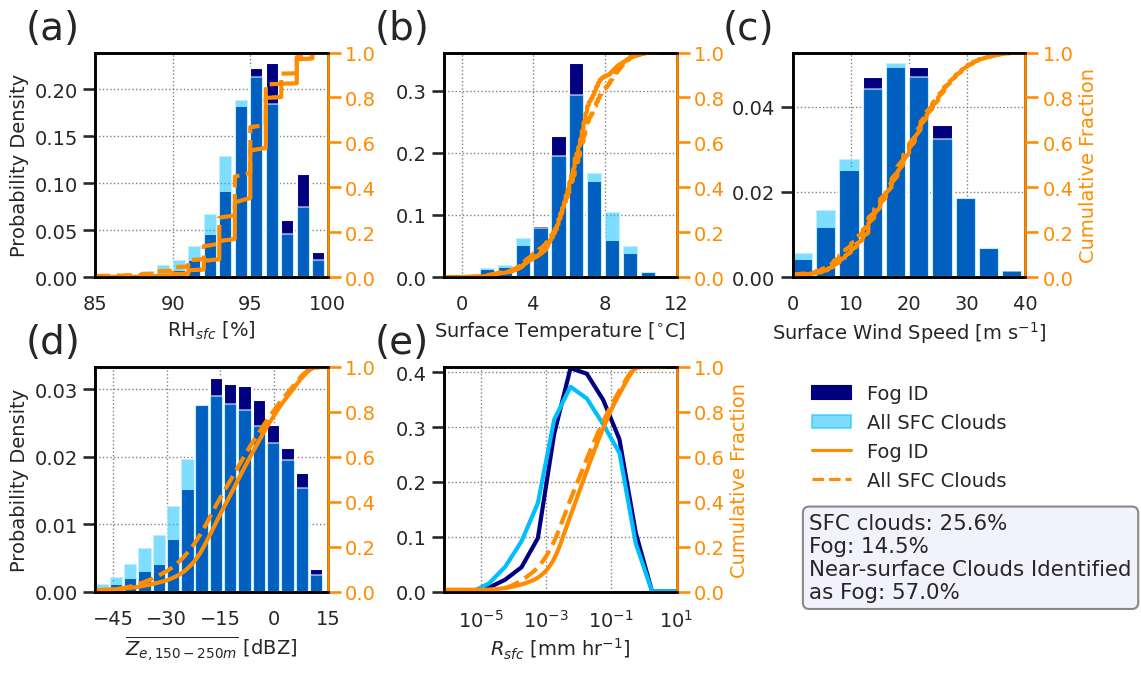

done


In [45]:
dumid = np.where((dum_cbh > -999.) & (dum_cbh < 250.))
dum2_cbh = dum_cbh[dumid]
dum2_cbt = dum_cbt[dumid]
dum2_sfc_rh = dum_sfc_rh[dumid]
dum2_sfc_wind_speed = dum_sfc_wind_speed[dumid]
dum2_fog_mask = dum_fog_mask[dumid]
dum2_sfc_ref_mean = dum_sfc_ref_mean[dumid]
dum2_sfc_temperature = dum_sfc_temperature[dumid]
dum2_sfc_vel_min = dum_sfc_vel_min[dumid]
dum2_sfc_rcb = dum_sfc_rcb[dumid]
dum2_sfc_cloud_binary = dum_sfc_cloud_binary[dumid]

fog2_id = np.where(dum2_fog_mask == 1.)


dumlw=3
dumstyle='dashed'
# Histograms of properties when fog_mask == 1.
#fog_id = fog_2_id
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('dark')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#dbz_id = np.where(dum_sfc_ref_mean > -999.)

fig = plt.figure(figsize=(12,7))
Fontsize=14
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
#ax6 = fig.add_subplot(236)
axlist = [ax1,ax2,ax3,ax4,ax5]
for ax in axlist:
    ax.grid(which='both',ls='dotted',lw=1,c='grey')
    ax.tick_params(labelsize=Fontsize)
    
# SFC RH
ax1.set_xlabel('RH$_{sfc}$ [%]',fontsize=Fontsize)
rh_bins = np.arange(50,101,1)
ax1.hist(dum2_sfc_rh[fog2_id],density=True,color='navy',bins=rh_bins,width=0.85,label='Fog ID')
#ax1.hist(dum_sfc_rh[dum_sfc_rh > 0.],density=True,color='deepskyblue',bins=rh_bins,width=0.75,align='mid',alpha=0.5,label='All SFC measurements')
dum_rh = dum2_sfc_rh[dum2_sfc_rh > 0.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_rh > 0.]
#dum_dbz_id = np.where(dum_dbz > -999.)
ax1.hist(dum_rh,density=True,color='deepskyblue',bins=rh_bins,width=0.85,align='mid',alpha=0.5,label='All SFC Clouds')

#CDF
# No of data points used
N = len(dum2_sfc_rh[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_rh[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax1a = ax1.twinx()
#ax1a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
ax1a.set_ylim(0,1)
ax1a.plot(x,y,c='darkorange',lw=dumlw)
ax1a.set_xlim(85,100)
ax1a.tick_params(labelsize=Fontsize,color='darkorange')
ax1a.spines['right'].set_color('darkorange')
ax1a.tick_params(axis='y', colors='darkorange')
ax1a.grid(None)

# All sfc clouds
N = len(dum2_sfc_rh[dum2_sfc_rh > 0.])
x = np.sort(dum2_sfc_rh[dum2_sfc_rh > 0.])
y = np.arange(N) / float(N)
ax1a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)



# SFC Temperature
ax2.set_xlabel('Surface Temperature [$^{\\circ}$C]',fontsize=Fontsize)
temp_bins = np.arange(-20,22,1)
ax2.hist(dum2_sfc_temperature[fog2_id],density=True,color='navy',bins=temp_bins,width=0.85)
#ax2.hist(dum_sfc_temperature[dum_sfc_temperature > -999.],density=True,color='deepskyblue',bins=temp_bins,width=0.75,align='mid',alpha=0.5)
#ax2.hist(dum_sfc_temperature[dbz_id],density=True,color='deepskyblue',bins=temp_bins,width=0.75,align='mid',alpha=0.5)
dum_temp = dum2_sfc_temperature[dum2_sfc_temperature > -999.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_temperature > -999.]
#dum_dbz_id = np.where(dum_dbz > -999.)
ax2.hist(dum_temp,density=True,color='deepskyblue',bins=temp_bins,width=0.85,align='mid',alpha=0.5)

ax2.set_xlim(-1,12)

#CDF
# No of data points used
N = len(dum2_sfc_temperature[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_temperature[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax2a = ax2.twinx()
#ax2a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
ax2a.set_ylim(0,1)
ax2a.plot(x,y,c='darkorange',lw=dumlw)
ax2a.set_xlim(-1,12)
ax2a.tick_params(labelsize=Fontsize,color='darkorange')
ax2a.spines['right'].set_color('darkorange')
ax2a.tick_params(axis='y', colors='darkorange')
ax2a.grid(None)

# All sfc clouds
N = len(dum2_sfc_temperature[dum2_sfc_temperature > -999.])
x = np.sort(dum2_sfc_temperature[dum2_sfc_temperature > -999.])
y = np.arange(N) / float(N)
ax2a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)


# SFC Wind Speed
ax3.set_xlabel('Surface Wind Speed [m s$^{-1}$]',fontsize=Fontsize)
wind_speed_bins = np.arange(0,44,4)
ax3.hist(dum2_sfc_wind_speed[fog2_id],density=True,color='navy',bins=wind_speed_bins,width=3.5,align='mid')
#ax3.hist(dum_sfc_wind_speed[dum_sfc_wind_speed > 0.],density=True,color='deepskyblue',bins=wind_speed_bins,width=3.5,align='mid',alpha=0.5)
dum_wind_speed = dum2_sfc_wind_speed[dum2_sfc_wind_speed > -999.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_wind_speed > -999.]
#dum_dbz_id = np.where(dum_dbz > -999.)
ax3.hist(dum_wind_speed,density=True,color='deepskyblue',bins=wind_speed_bins,width=3.5,align='mid',alpha=0.5)

#CDF
# No of data points used
N = len(dum2_sfc_wind_speed[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_wind_speed[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax3a = ax3.twinx()
ax3a.set_ylabel('Cumulative Fraction',fontsize=Fontsize,c='darkorange')
ax3a.set_ylim(0,1)
ax3a.plot(x,y,c='darkorange',lw=dumlw)
ax3a.set_xlim(0,40)
ax3a.tick_params(labelsize=Fontsize,color='darkorange')
ax3a.spines['right'].set_color('darkorange')
ax3a.tick_params(axis='y', colors='darkorange')
ax3a.grid(None)

# All sfc clouds
N = len(dum2_sfc_wind_speed[dum2_sfc_wind_speed > -999.])
x = np.sort(dum2_sfc_wind_speed[dum2_sfc_wind_speed > -999.])
y = np.arange(N) / float(N)
ax3a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

# SFC Mean Refletivity 
ax4.set_xlabel('$\\overline{Z_{e,150-250m}}$ [dBZ]',fontsize=Fontsize)
dbz_bins = np.arange(-50,24,4)
ax4.hist(dum2_sfc_ref_mean[fog2_id],density=True,color='navy',bins=dbz_bins,width=3.75)
ax4.hist(dum2_sfc_ref_mean[dum2_sfc_ref_mean > -999.],density=True,color='deepskyblue',bins=dbz_bins,width=3.75,align='mid',alpha=0.5)

#CDF
# No of data points used
N = len(dum2_sfc_ref_mean[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_ref_mean[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax4a = ax4.twinx()
#ax4a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
ax4a.set_ylim(0,1)
ax4a.plot(x,y,c='darkorange',lw=dumlw)
ax4a.set_xlim(-50,24)
ax4a.tick_params(labelsize=Fontsize,color='darkorange')
ax4a.spines['right'].set_color('darkorange')
ax4a.tick_params(axis='y', colors='darkorange')
ax4a.grid(None)

# All sfc clouds
N = len(dum2_sfc_ref_mean[dum2_sfc_ref_mean > -999.])
x = np.sort(dum2_sfc_ref_mean[dum2_sfc_ref_mean > -999.])
y = np.arange(N) / float(N)
ax4a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

if False:
    # SFC Min VDop
    ax5.set_xlabel('Min. $V_{Dop,150-250m}}$ [m s$^{-1}$]',fontsize=Fontsize)
    vel_bins = np.arange(-6.,1.5,0.5)
    ax5.hist(dum_sfc_vel_min[fog_id],density=True,color='navy',bins=vel_bins,width=0.4)
    #ax5.hist(dum_sfc_vel_min[dum_sfc_vel_min > -999.],density=True,color='deepskyblue',bins=vel_bins,width=0.4,align='mid',alpha=0.5)
    dum_vel_min = dum_sfc_vel_min[dum_sfc_vel_min > -999.]
    dum_dbz = dum_sfc_ref_mean[dum_sfc_vel_min > -999.]
    dum_dbz_id = np.where(dum_dbz > -999.)
    ax5.hist(dum_vel_min[dum_dbz_id],density=True,color='deepskyblue',bins=vel_bins,width=0.4,align='mid',alpha=0.5)




    #CDF
    # No of data points used
    N = len(dum_sfc_vel_min[fog_id])  
    # sort the data in ascending order
    x = np.sort(dum_sfc_vel_min[fog_id])
    # get the cdf values of y
    y = np.arange(N) / float(N)
    ax5a = ax5.twinx()
    #ax5a.set_ylabel('Cumulative Probability',fontsize=Fontsize,c='darkorange')
    ax5a.set_ylim(0,1)
    ax5a.plot(x,y,c='darkorange',lw=dumlw)
    ax5a.set_xlim(-6,1.5)
    ax5a.tick_params(labelsize=Fontsize,color='darkorange')
    ax5a.spines['right'].set_color('darkorange')
    ax5a.tick_params(axis='y', colors='darkorange')
    ax5a.grid(None)

    # All sfc clouds
    N = len(dum_sfc_vel_min[dum_sfc_vel_min > -999.])
    x = np.sort(dum_sfc_vel_min[dum_sfc_vel_min > -999.])
    y = np.arange(N) / float(N)
    ax5a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

# SFC Precip Rate

ax5.set_xlabel('$R_{sfc}$ [mm hr$^{-1}$]',fontsize=Fontsize)
R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])
a,bin_edges = np.histogram(np.log10(dum2_sfc_rcb[fog2_id]),bins=R_bins,density=True)
ax5.plot(10.**(midbins),a,lw=dumlw,c='navy')
dum_rcb = dum2_sfc_rcb[dum2_sfc_rcb > -999.]
#dum_dbz = dum_sfc_ref_mean[dum_sfc_rcb > -999.]
#dum_dbz_id = np.where(dum_dbz > -999.)
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
#ax6.plot(10.**(midbins),a,lw=3,c='deepskyblue')
ax5.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue')

ax5.set_xscale('log')

#CDF
# No of data points used
N = len(dum2_sfc_rcb[fog2_id])  
# sort the data in ascending order
x = np.sort(dum2_sfc_rcb[fog2_id])
# get the cdf values of y
y = np.arange(N) / float(N)
ax5a = ax5.twinx()
ax5a.set_ylabel('Cumulative Fraction',fontsize=Fontsize,c='darkorange')
ax5a.set_ylim(0,1)
ax5a.plot(x,y,c='darkorange',lw=dumlw)
ax5a.set_xlim(-6,2.5)
ax5a.tick_params(labelsize=Fontsize,color='darkorange')
ax5a.spines['right'].set_color('darkorange')
ax5a.tick_params(axis='y', colors='darkorange')
ax5a.grid(None)

# All sfc clouds
N = len(dum2_sfc_rcb[dum2_sfc_rcb > -999.])
x = np.sort(dum2_sfc_rcb[dum2_sfc_rcb > -999.])
y = np.arange(N) / float(N)
ax5a.plot(x,y,c='darkorange',lw=dumlw,ls=dumstyle)

ax5.set_ylim(0,0.41)

# Legend
from matplotlib.lines import Line2D

navy_patch = mpatches.Patch(color='navy',alpha=1,label='Fog ID')
deepskyblue_patch = mpatches.Patch(color='deepskyblue',alpha=0.5,label='All SFC Clouds')
solid_orange_line = Line2D([0], [0],color='darkorange',ls='solid',label='Fog ID',)
dashed_orange_line = Line2D([0], [0],color='darkorange',ls='dashed',label='All SFC Clouds')

#lgnd1 = ax5.legend(handles=[navy_patch,deepskyblue_patch,solid_orange_line,dashed_orange_line],\
#                    fontsize=Fontsize,\
#                    bbox_to_anchor=(2,0.9),\
#                    ncol=1,loc='upper center',framealpha=0)



ax4.set_xlim(-50,15)
dumlist = [-45,-30,-15,0,15]
ax4.set_xticks(dumlist)
dumlist = [1.e-5,1.e-3,1.e-1,1.e1]
ax5.set_xticks(dumlist)
dumlist = [0,10,20,30,40]
ax3.set_xticks(dumlist)
dumlist = [0,4,8,12]
ax2.set_xticks(dumlist)

xpos = -0.3
ypos = 1.06
fac = 2
ax1.text(xpos,ypos,'(a)',fontsize=Fontsize*fac,transform=ax1.transAxes)
ax2.text(xpos,ypos,'(b)',fontsize=Fontsize*fac,transform=ax2.transAxes)
ax3.text(xpos,ypos,'(c)',fontsize=Fontsize*fac,transform=ax3.transAxes)
ax4.text(xpos,ypos,'(d)',fontsize=Fontsize*fac,transform=ax4.transAxes)
ax5.text(xpos,ypos,'(e)',fontsize=Fontsize*fac,transform=ax5.transAxes)
#ax6.text(xpos,ypos,'(f)',fontsize=Fontsize*fac,transform=ax6.transAxes)

ax1.set_ylabel('Probability Density',fontsize=Fontsize)
ax4.set_ylabel('Probability Density',fontsize=Fontsize)



starty = 0.1
# % SFC Clouds
dumid = np.where(dum_cbh < 250.)
dumsize = np.size(dumid)/np.size(dum_cbh)*100.
sfc_perc = np.around(dumsize,1)
dumstr1 = 'SFC clouds: '+str(sfc_perc)+'%'
#plt.figtext(0.7,starty,dumstr,fontsize=Fontsize,fontweight='bold')

# % Fog
dumid = np.where(dum_fog_mask == 1)
dumsize = np.size(dumid)/np.size(dum_cbh)*100.
fog_perc = np.around(dumsize,1)
dumstr2 = 'Fog: '+str(fog_perc)+'%'
#plt.figtext(0.7,starty-0.08,dumstr,fontsize=Fontsize,fontweight='bold')

# % SFC Clouds IDd as fog
dumid = np.where((dum_fog_mask == 1.) & (dum_cbh < 250.))
dumsize = np.size(dumid)/np.size(dum_cbh[dum_cbh < 250.])*100.
fog_perc = np.around(dumsize,0)
dumstr3 = 'Near-surface Clouds Identified\nas Fog: '+str(fog_perc)+'%'

props = dict(boxstyle='round', facecolor='lavender', alpha=0.5, edgecolor='k')
dumstr = dumstr1+'\n'+dumstr2+'\n'+dumstr3
plt.figtext(0.72,starty,dumstr,fontsize=Fontsize*1.1,bbox=props)


lgnd1 = ax5.legend(handles=[navy_patch,deepskyblue_patch,solid_orange_line,dashed_orange_line],\
                    fontsize=Fontsize,\
                    bbox_to_anchor=(2,1.),\
                    ncol=1,loc='upper center',framealpha=0)

plt.subplots_adjust(wspace=0.5,hspace=0.4)
fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_10.png'
#outfile = 'fig_10.eps'
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

In [ ]:
#---------------------------------------------------------
#---------------------------------------------------------
# Joint Histogram of mean dbz and min. vel.
#---------------------------------------------------------
#---------------------------------------------------------


sns.set_theme()
sns.set_style('ticks')
#sns.set_style('dark')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('talk')
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)


def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
dum_dbz = dum_sfc_ref_mean.copy()
dum_vel = dum_sfc_vel_min.copy()
dum_fog = dum_fog_mask.copy()
dumid = np.where((dum_dbz > -999.) & (dum_vel > -999.))
dum_dbz = dum_dbz[dumid]
dum_vel = dum_vel[dumid]
dum_fog = dum_fog_mask[dumid]


# Joint histogram of CBT and Cloud Depth Precipitating Fraction
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
Fontsize=18
ax1.set_xlabel('Min. $V_{Dop,150-250m}}$ [m s$^{-1}$]',fontsize=Fontsize)
ax1.set_ylabel('$\\overline{Z_{e,150-250m}}$ [dBZ]',fontsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)

#-----------------------------------------
# All Clouds
#-----------------------------------------
var1 = dum_vel.copy()
var2 = dum_dbz.copy()
dumvar1_bins = np.arange(-7,2.5,0.5)
dumvar1_midbins = np.array([(dumvar1_bins[dd] + dumvar1_bins[dd+1])/2. for dd in range(len(dumvar1_bins)-1)])
dumvar2_bins = np.arange(-60,24,2)
dumvar2_midbins = np.array([(dumvar2_bins[dd] + dumvar2_bins[dd+1])/2. for dd in range(len(dumvar2_bins)-1)])

levs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]
dum_hist,_,_ = np.histogram2d(var1,var2,bins=[dumvar1_bins,dumvar2_bins],density=True)
dumplot = ax1.contour(dumvar1_midbins,dumvar2_midbins,dum_hist.T,levels=levs,colors='deepskyblue')

#dum_cmin = 10
#dumplot = ax1.hist2d(var1,var2,bins=20,cmap='inferno',norm=matplotlib.colors.LogNorm(),density=False,cmin=dum_cmin)
#cbar = plt.colorbar(dumplot[3],ax=ax1)
#cbar.ax.tick_params(labelsize=Fontsize)
#cbar.ax.set_ylabel('Relative Frequency',fontsize=Fontsize)
#cbar.ax.set_yticks([1.e1,1.e2,1.e3,1.e4])

#-----------------------------------------
# Fog
#-----------------------------------------
var1 = dum_vel.copy()[dum_fog == 1.]
var2 = dum_dbz.copy()[dum_fog == 1.]
dumvar1_bins = np.arange(-7,2.5,0.5)
dumvar2_bins = np.arange(-60,24,2)

levs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50]
dum_hist,_,_ = np.histogram2d(var1,var2,bins=[dumvar1_bins,dumvar2_bins],density=True)
dumplot = ax1.contour(dumvar1_midbins,dumvar2_midbins,dum_hist.T,levels=levs,colors='navy')

ax1.grid(which='both',ls='dotted',c='dimgrey',lw=1)
ax1.legend(loc='upper center')
#fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_07.png'
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()       

In [ ]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Calculate percentage of layers with no reflectivity at cloud base
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
dumid = np.where(var_dict_cloud['ref_at_cbh_binary'] == 0.)
print('% profiles w/ no reflectivity at cloud base: {} %'.format(np.size(dumid)/np.size(var_dict_cloud['ref_at_cbh_binary'])*100.))

In [ ]:
client.shutdown()

In [ ]:
dum = var_dict_cloud['ref_within_100m_above_cbh_binary']
dum2 = var_dict_cloud['ref_at_cbh_binary']
print(np.unique(dum))
print(np.unique(dum2))
dumid = np.where(dum == -999.)
print(np.size(dumid)/np.size(dum)*100.)
dumid = np.where(dum == 0.)
print(np.size(dumid)/np.size(dum)*100.)
dumid = np.where(dum == 1.)
print(np.size(dumid)/np.size(dum)*100.)
dumid = np.where(dum2 == -999.)
print(np.size(dumid)/np.size(dum2)*100.)
dumid = np.where(dum2 == 0.)
print(np.size(dumid)/np.size(dum2)*100.)
dumid = np.where(dum2 == 1.)
print(np.size(dumid)/np.size(dum2)*100.)
dumid = np.where(np.isnan(dum2))
print(np.size(dumid)/np.size(dum2)*100.)

In [ ]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Remove updrafts
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
no_updraft_id = np.where((var_dict_2['precip_updraft_binary'] == 0.) | (var_dict_2['precip_updraft_binary'] == -999.))[0]
print(np.size(no_updraft_id))
for key in var_dict_2.keys():
    #print(key)
    var_dict_2[key] = var_dict_2[key][no_updraft_id]

In [ ]:
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
# Calculate Various Fractions
#---------------------------------------------------------------
#---------------------------------------------------------------
#---------------------------------------------------------------
cbh = var_dict_2['cbh']
cbt = var_dict_2['cbt']
cth = var_dict_2['cth']
ctt = var_dict_2['ctt']
c_thick = var_dict_2['c_thick']
fog_mask = var_dict_2['fog_mask']
ref_at_cbh_binary = var_dict_2['ref_at_cbh_binary']
cloud_binary = var_dict_2['cloud_binary']
precip_binary = var_dict_2['precip_binary']
ceil_detection_status = var_dict_2['ceil_detection_status']

cloud_cbh = var_dict_cloud['cbh']
cloud_cbt = var_dict_cloud['cbt']
cloud_cth = var_dict_cloud['cth']
cloud_ctt = var_dict_cloud['ctt']
cloud_c_thick = var_dict_cloud['c_thick']
cloud_ref_at_cbh_binary = var_dict_cloud['ref_at_cbh_binary']


sfc_cloud_cbh = var_dict_sfc_cloud['cbh']
sfc_cloud_cbt = var_dict_sfc_cloud['cbt']
sfc_cloud_cth = var_dict_sfc_cloud['cth']
sfc_cloud_ctt = var_dict_sfc_cloud['ctt']
sfc_cloud_c_thick = var_dict_sfc_cloud['c_thick']

#------------------------------------------------------------
# Total Cloud Fraction
#------------------------------------------------------------
dum_size_1 = np.size(cbh[cbh > 0.])
dum_size_2 = np.size(cbh[~np.isnan(cbh)])
print('Total Cloud Occurrence Frequency:',dum_size_1/dum_size_2*100.)
print((np.size(cloud_binary[cloud_binary == 1.]) + np.size(cloud_binary[cloud_binary == -1]))/np.size(cloud_binary)*100.)
#------------------------------------------------------------
# Fraction of layers with obscured ceilometer signal
#------------------------------------------------------------
dum_size_1 = np.size(ceil_detection_status[ceil_detection_status == 4.])
dum_size_2 = np.size(ceil_detection_status[~np.isnan(ceil_detection_status)])
print('Obscured Ceilometer Occurrence Frequency:',dum_size_1/dum_size_2*100.)

#------------------------------------------------------------
# Fraction of Clouds w/ CBH > 250.
#------------------------------------------------------------
dum_size_1 = np.size(cbh[cbh > 250.])
dum_size_2 = np.size(cbh[cbh > 0.])
print('% of Clouds w/ CBH > 250 m:',dum_size_1/dum_size_2*100.)

#------------------------------------------------------------
# Fraction of SFC-based clouds (CBH < 250 m)
#------------------------------------------------------------
dum_size_1 = np.size(np.where( (cbh > 0.) & (cbh < 250.) ) )
dum_size_2 = np.size(cbh[cbh > 0.])
print('% of SFC-based clouds (CBH < 250 m):',dum_size_1/dum_size_2*100.)
    
    
#------------------------------------------------------------
# Conditional Cloud Occurrence frequency based only on CBT for
# elevated clouds
#------------------------------------------------------------
# Supercooled
dum_size_1 = np.size(np.where( (cbt > -999.) & (cbt < 0.) & (cbh > 250.) ))
dum_size_2 = np.size(np.where( (cbt > -999.) & (cbh > 250.)))
print('% supercooled clouds based on CBT only :',dum_size_1/dum_size_2*100.)

# Warm
dum_size_1 = np.size(np.where( (cbt > -999.) & (cbt >= 0.) & (cbh > 250.) ))
dum_size_2 = np.size(np.where( (cbt > -999.)))
print('% warm clouds based on CBT only :',dum_size_1/dum_size_2*100.)


#------------------------------------------------------------
# Fraction of clouds with CEIL only - only for elevated clouds
#------------------------------------------------------------
#All
dum_size_1 = np.size(np.where( (ref_at_cbh_binary == 0.) & (cbt > -999.) & (cbh > 250.) & (cbt > -38.) ) )
dum_size_2 = np.size(np.where( (cbt > -999.) & (ref_at_cbh_binary > -999.) & (cbh > 250.) & (cbt > -38.) ) )
print('% of clouds w/ CEIL only:',dum_size_1/dum_size_2*100.)

# Supercooled
dum_size_1 = np.size(np.where( (ref_at_cbh_binary == 0.) & (cbt > -999.) & (cbt < 0.) & (cbh > 250.) ) )
dum_size_2 = np.size(np.where( (cbt > -999.) & (ref_at_cbh_binary == 0.) ) )
print('% supercooled clouds w/ CEIL only:',dum_size_1/dum_size_2*100.)

# Warm
dum_size_1 = np.size(np.where( (ref_at_cbh_binary == 0.) & (cbt > -999.) & (cbt >= 0.) & (cbh > 250.) ) )
dum_size_2 = np.size(np.where( (cbt > -999.) & (ref_at_cbh_binary == 0.) & (cbh > 250.) ) )
print('% warm clouds w/ CEIL only:',dum_size_1/dum_size_2*100.)

#print('Cloud Fraction (% of data points with CBH at any height):',(np.size(cbh[cbh > 0.])/np.size(cbh[~np.isnan(cbh)]))*100.)
#supercooled_id = np.where( (cbt > -999.) & (cth > -999.) & (cbt < 0.) & (cth < 0.) )
#partially_supercooled_id = np.where( (cbt > -999.) & (cth > -999.) & (cbt >= 0.) & (cth < 0.) )
#partially_supercooled_id = np.where( (cbt > -999.) & (cth > -999.) & (cbt >= 0.) & (cth < 0.) )

#print('% of data points with CBH == -999.:',np.size(cbh_binary_neg999_id)/np.size(cbh)*100.)
#print('% of data points with CBH < 250):',np.size(cbh_bel_min_binary_id)/np.size(cbh_bel_min_binary)*100.)
##print('% of datapoints with seconds_to_nearest_sounding == -999.:',np.size(seconds_to_nearest_sounding_neg999_id)/np.size(seconds_to_nearest_sounding)*100.)
#print('% of datapoints w/ cloud but no reflectivity at cloud base:',np.size(ref_at_cbh_binary_id)/np.size(ref_at_cbh_binary[cloud_id])*100.)
#print('% of datapoints w/ attenuated backscatter profile indicative of fog (< 250 m):',np.size(fog_mask_id)/np.size(fog_mask)*100.)
#print('% of datapoints w/ attenuated backscatter profile indicative of fog (all heights):',np.size(fog_mask_2_id)/np.size(fog_mask_2)*100.)